In [4]:
if (!require("data.table")) install.packages("data.table")
library ("data.table")

In [5]:
if (!require("TSA")) install.packages("TSA")
library ("TSA")

In [6]:
if (!require("vars")) install.packages("vars")
library ("vars")

# Load Data

In [7]:
#Load data
data=read.csv("BostonSnowPredict.csv",header=TRUE)

#Split data into training and testing
data_split=data[,c(2,3,4,5)]
snow.train=data_split[1:(nrow(data)-4),]
snow.test=data_split[(nrow(data_split)-3):nrow(data_split),]


_Question 1: Data Exploration_ 

_Explore trends and stationarity of the time series. Comment on any trends, seasonality, or other characterizing features of the four time series.
Take the 1st order difference of the data. Display the transformed time series._

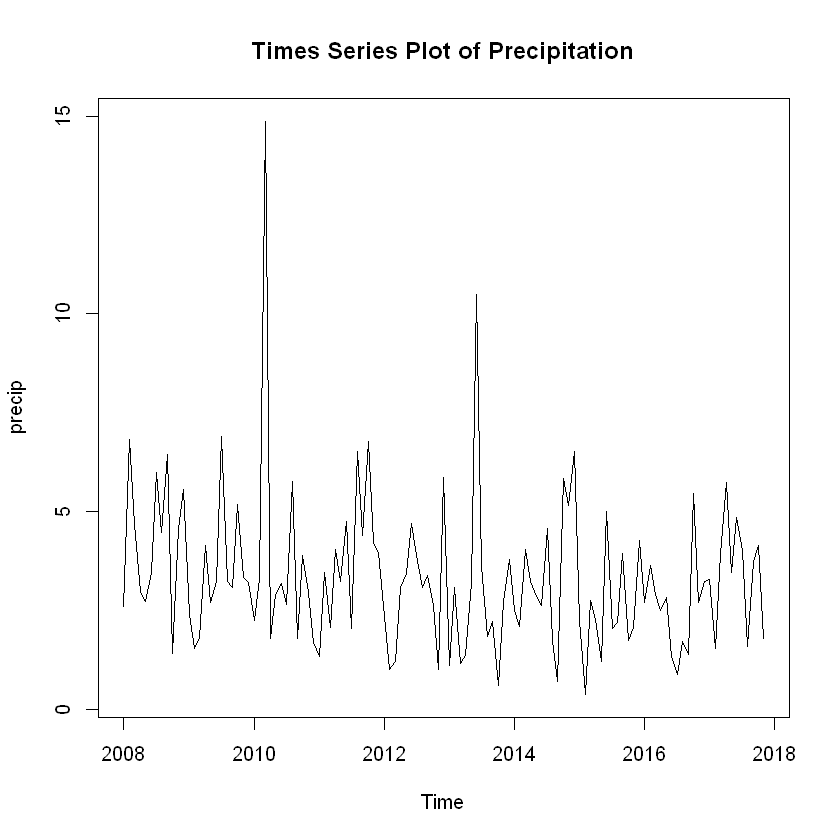

In [9]:
# assign names according to training data
precip = ts(snow.train$Precip,start=2008,frequency = 12)
dew = ts(snow.train$AverageDewPoint,start=2008,frequency = 12)
pressure = ts(snow.train$AverageSeaLevelPressure,start=2008,frequency = 12)
soi = ts(snow.train$SOI,start=2008,frequency = 12)

# plot time series
ts.plot(precip,main = "Times Series Plot of Precipitation")




From the time series plot of precipitaiton, it can be seen that there is a slight downward trend. The variance is not consistent because there are a couple larger spikes.

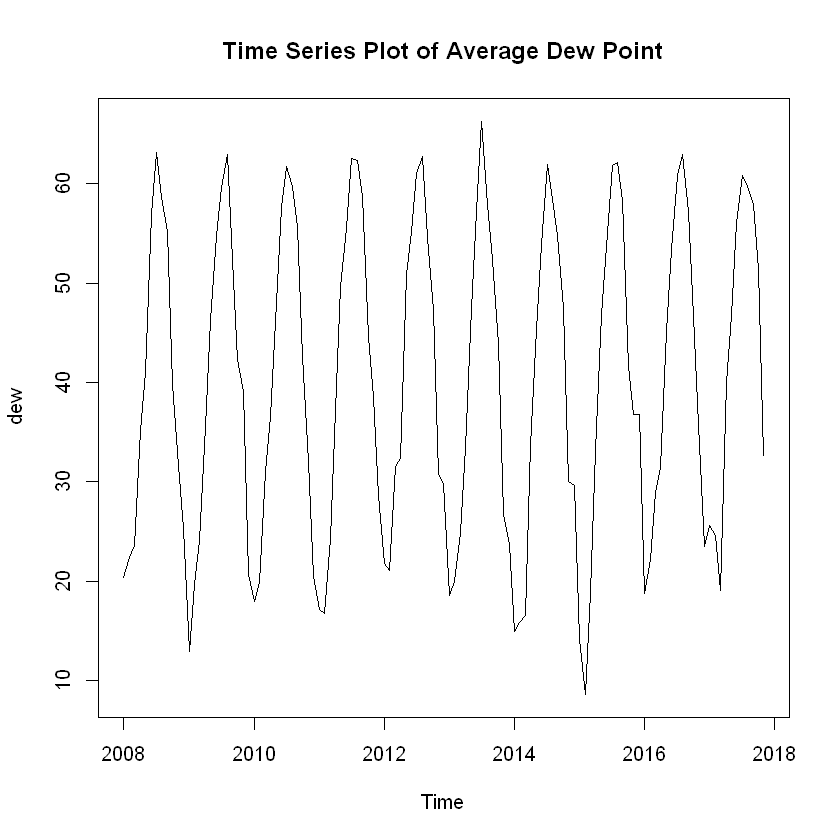

In [10]:
ts.plot(dew,main = "Time Series Plot of Average Dew Point")

The time series of Mean Dew Point showed relatively constant mean and variance, and seasonality can be clearly seem. which assembles a stationary time series

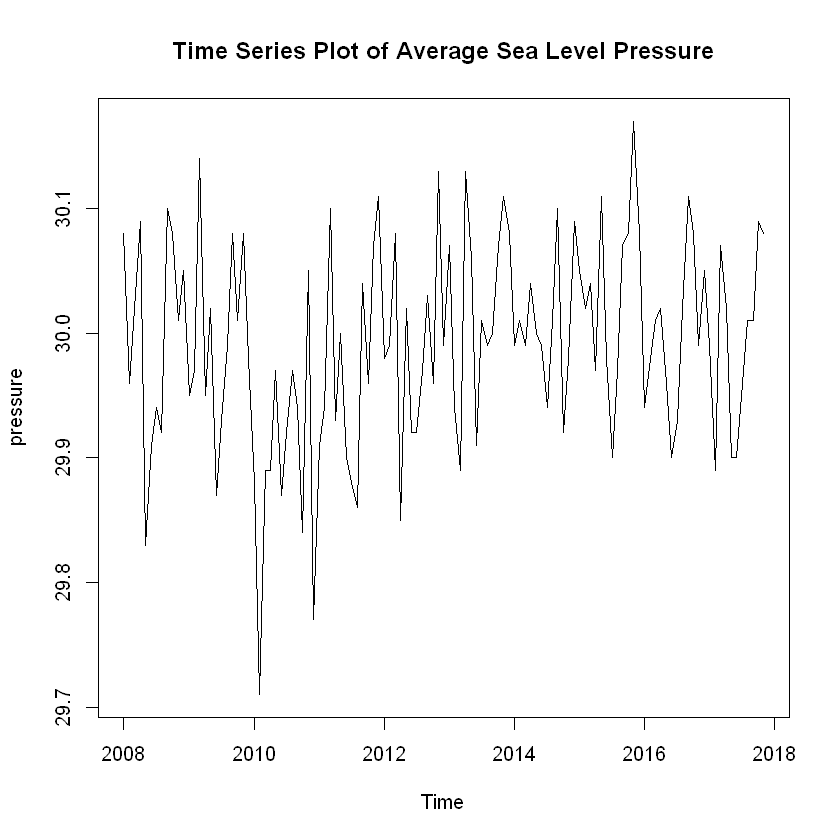

In [11]:
ts.plot(pressure,main = "Time Series Plot of Average Sea Level Pressure")

The time series of pressure showed relatively constant mean except in the range of 2010 to 2011, and the variance is not constant throughout the time series. There seemed to be seasonality, for example, the pressure seemed to decrease at the first quater of a year.

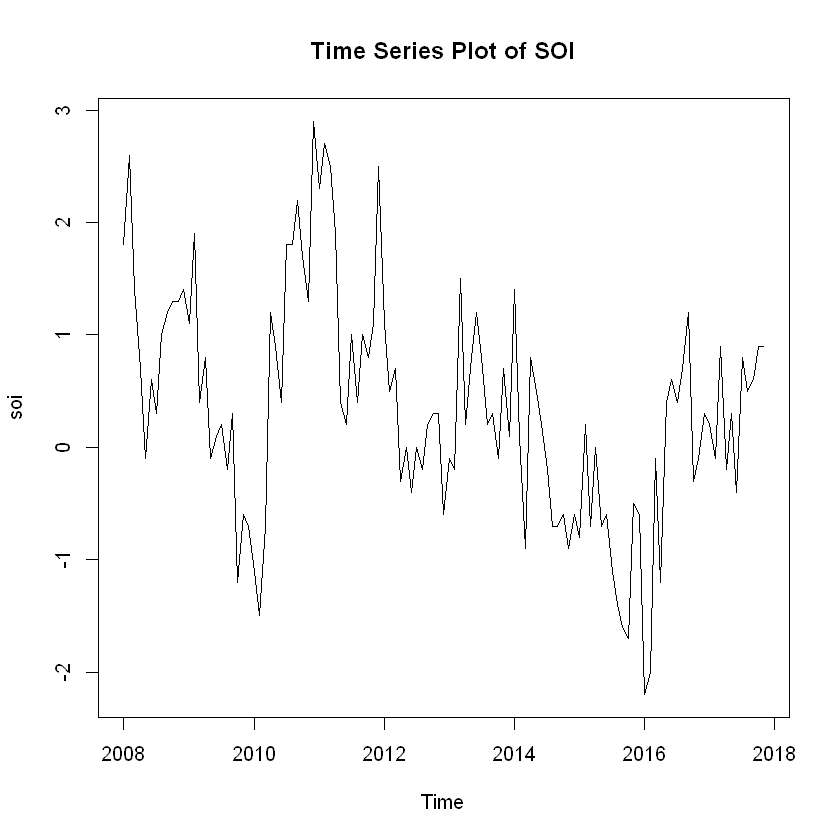

In [12]:
ts.plot(soi,main = "Time Series Plot of SOI")

The time series of SOI showed non-constant meanand there is a downward trend after 2012. The variance is also not constant.The seasonality is hard to see from the time series plot as there are a lot of fluctuation.  

_Take the 1st order difference of the data. Display the transformed time series._

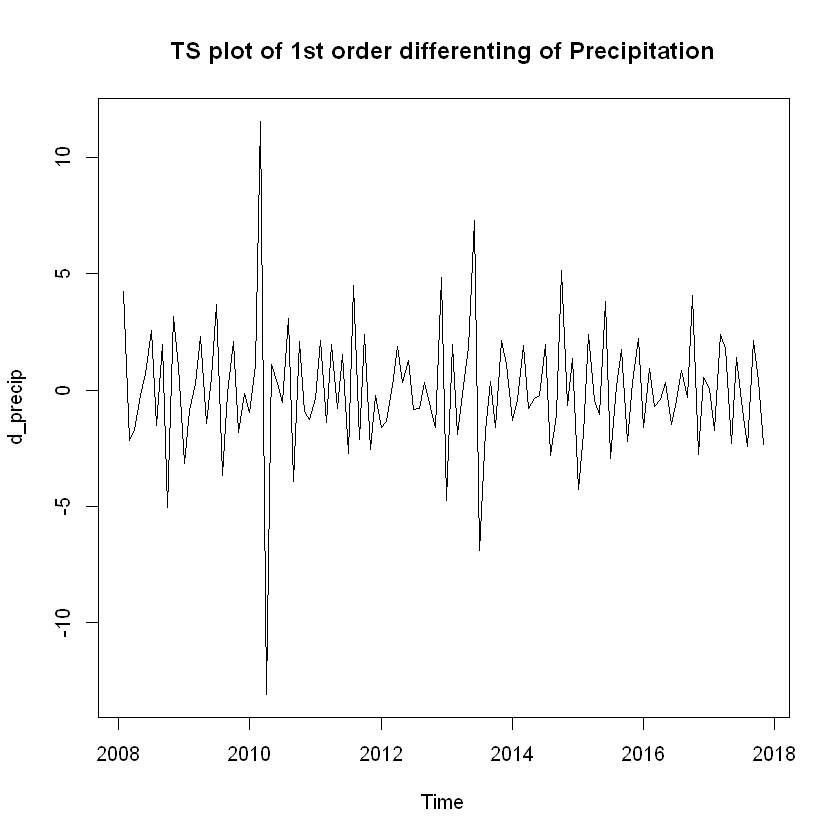

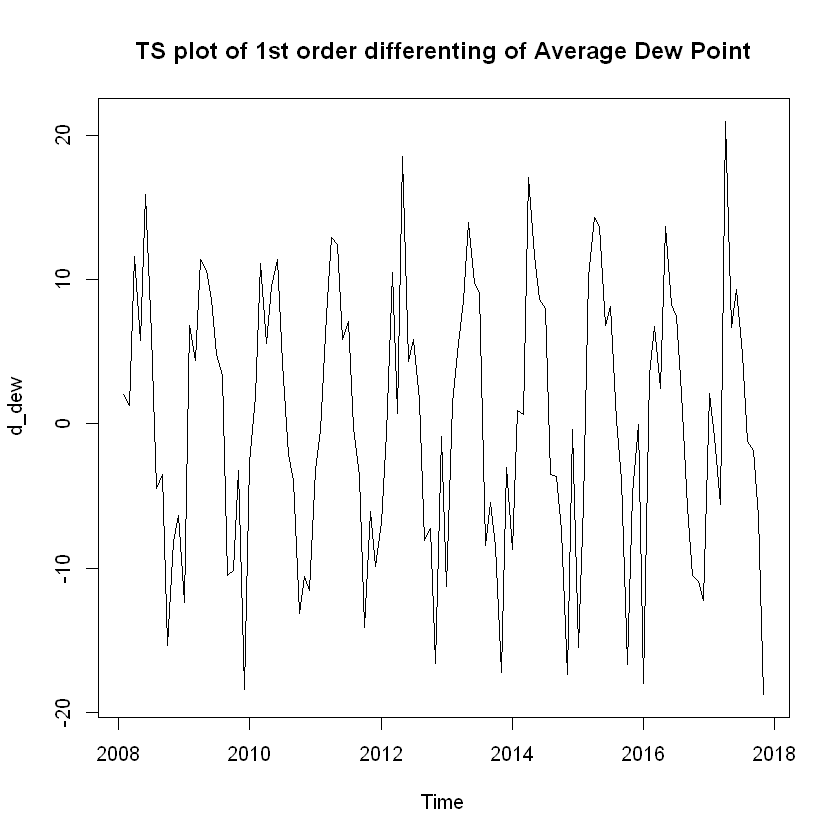

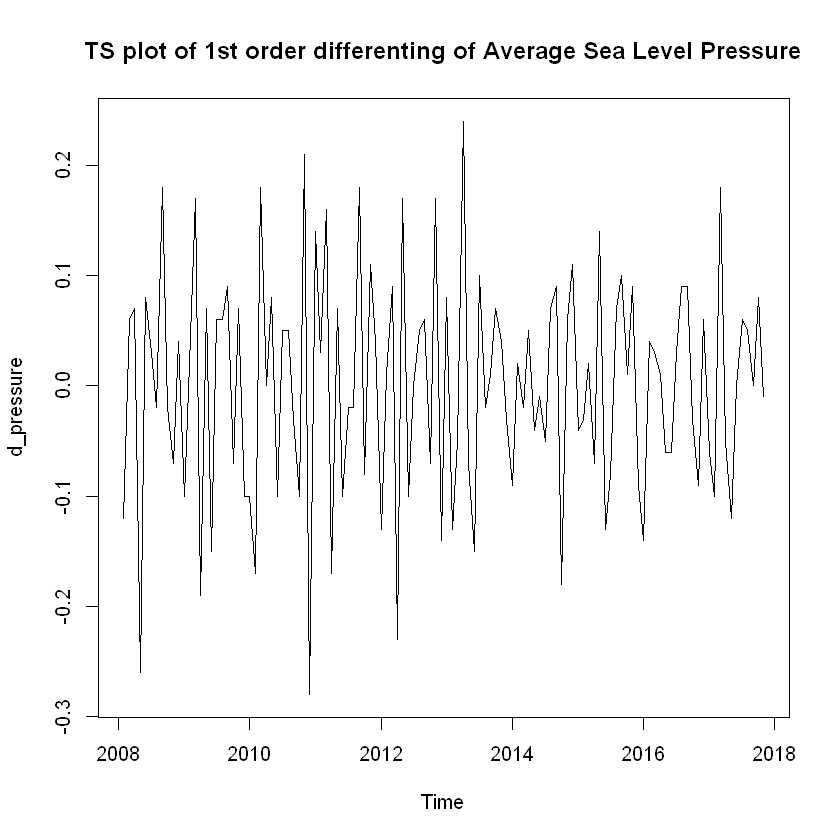

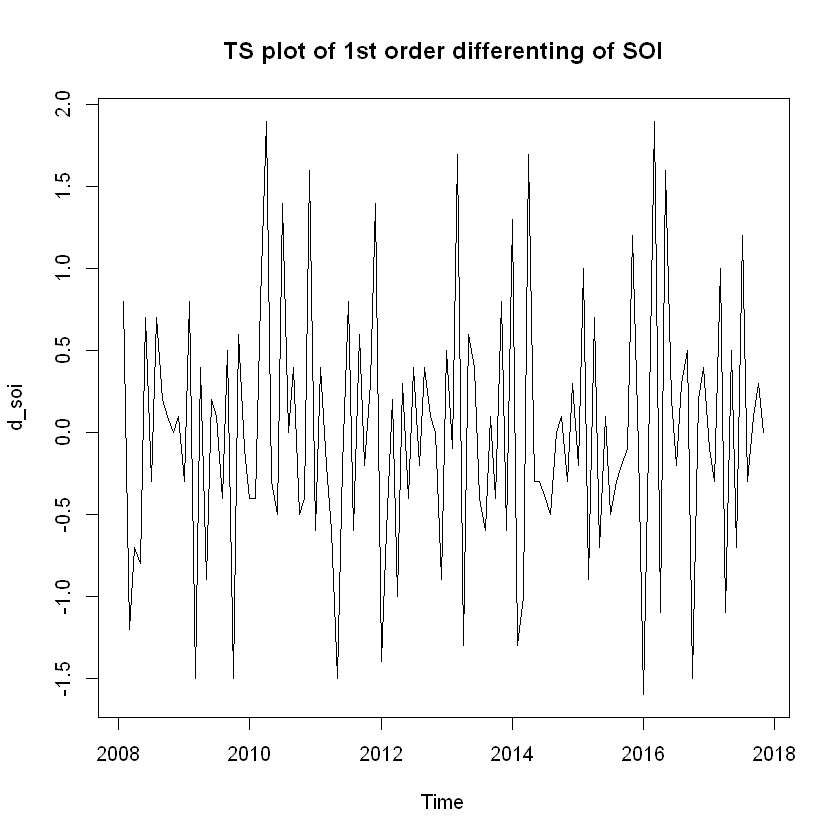

In [13]:
d_precip = diff(precip)
ts.plot(d_precip, main = "TS plot of 1st order differenting of Precipitation")

d_dew = diff(dew)
ts.plot(d_dew, main = "TS plot of 1st order differenting of Average Dew Point")

d_pressure = diff(pressure)
ts.plot(d_pressure, main = "TS plot of 1st order differenting of Average Sea Level Pressure")

d_soi = diff(soi)
ts.plot(d_soi, main = "TS plot of 1st order differenting of SOI")

_Question 2: Univariate Analysis_

_Identify the best ARIMA model that fits each of the time series according to each of the following 3 criteria: ACF/PACF, EACF and AIC (limit the maximum orders to 6). 
A total of 12 models, one for each series and criteria pair, should be identified in your solution. 
Then, choose one final ARIMA model for each series.
Give parameter estimates and their 95% CI's for the chosen fitted models for each series.
Plot the forecasts for the last four months of the data for the four time series against the actual observations._

Use ACF PACF Approach

In [17]:
plot_ACF_PACF = function(ts_data, ts_name = "Time Series"){
  par(mfrow=c(2,1))
  acf(as.numeric(ts_data), main = paste("ACF plot of", ts_name))
  pacf(as.numeric(ts_data),main = paste("PACF plot of", ts_name))
}

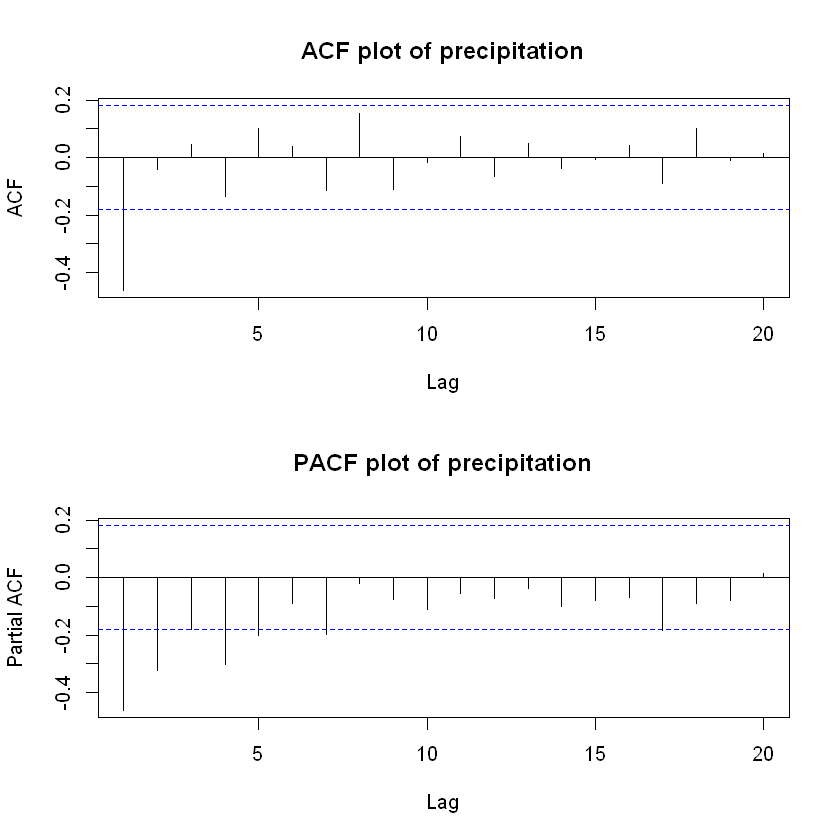

In [18]:
plot_ACF_PACF(d_precip, ts_name = "precipitation")

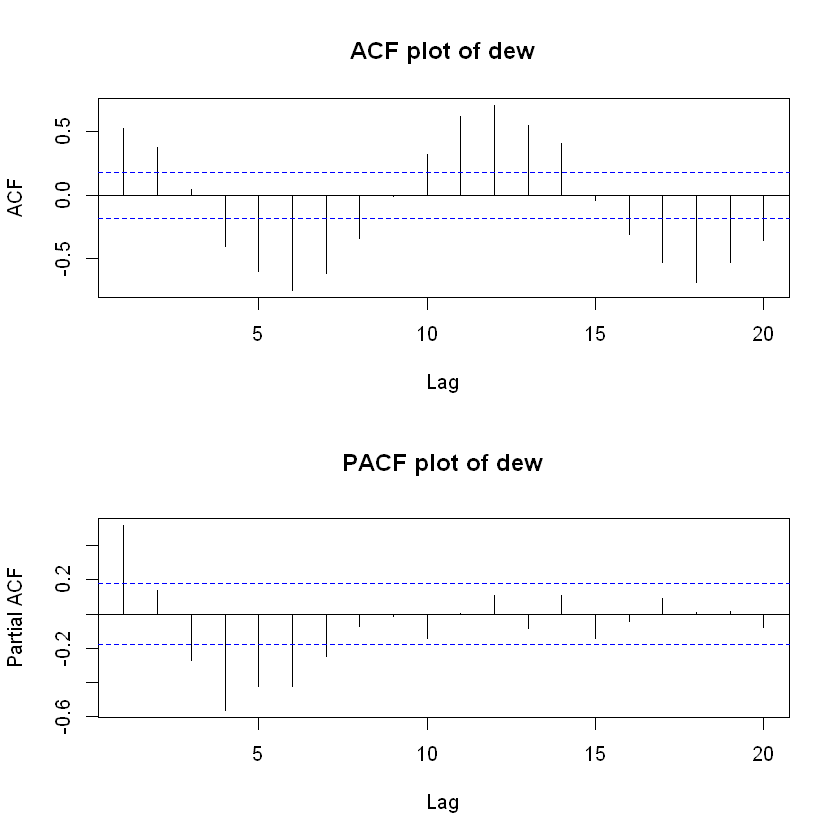

In [19]:
plot_ACF_PACF(d_dew,ts_name = "dew")

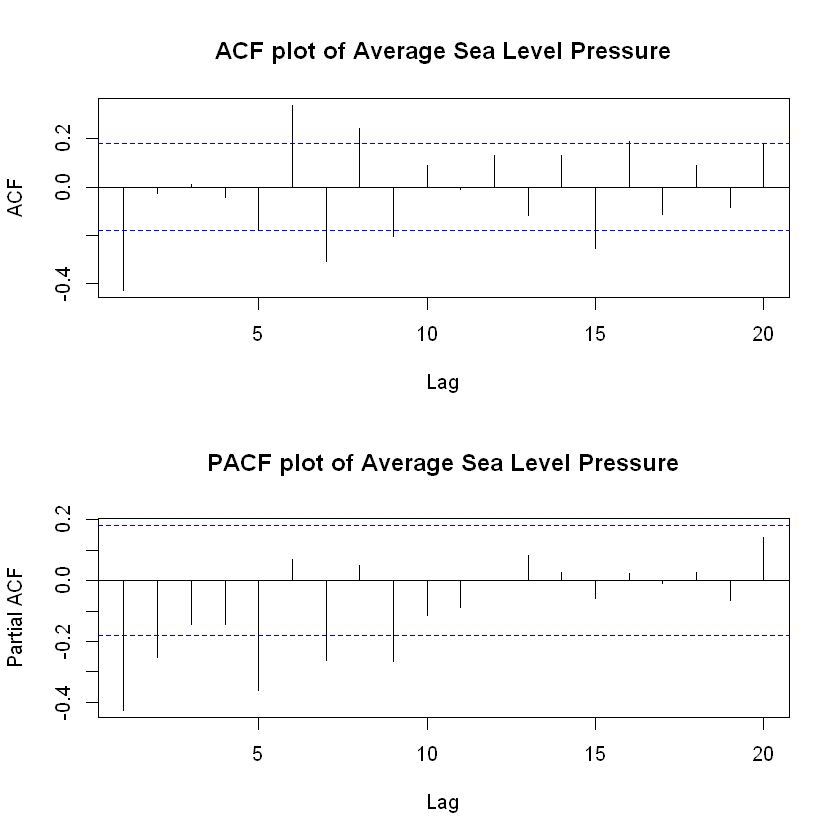

In [20]:
plot_ACF_PACF(d_pressure,ts_name = "Average Sea Level Pressure")

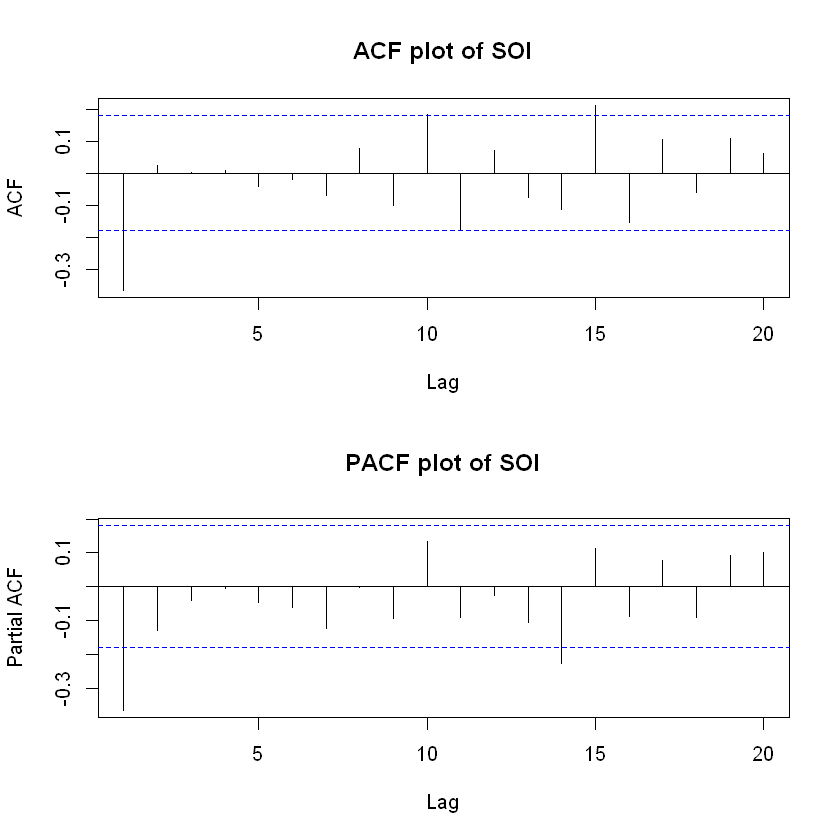

In [21]:
plot_ACF_PACF(d_soi, ts_name = "SOI")

Use EACF Approach

In [22]:
cat("EACF Matrix of Precipitation \n")
eacf(d_precip)
cat("---------------------------------\n")
cat("EACF Matrix of dew \n")
eacf(d_dew)
cat("---------------------------------\n")
cat("EACF Matrix of Sea Level Pressure \n")
eacf(d_pressure)
cat("---------------------------------\n")
cat("EACF Matrix of SOI \n")
eacf(d_soi)
cat("---------------------------------\n")

EACF Matrix of Precipitation 
AR/MA
  0 1 2 3 4 5 6 7 8 9 10 11 12 13
0 x o o o o o o o o o o  o  o  o 
1 x x o o o o o o o o o  o  o  o 
2 x x o o o o o o o o o  o  o  o 
3 x x x x o o o o o o o  o  o  o 
4 x o x x x o o o o o o  o  o  o 
5 x o x x o o o o o o o  o  o  o 
6 x x x x o x o o o o o  o  o  o 
7 x x x x x o o o o o o  o  o  o 
---------------------------------
EACF Matrix of dew 
AR/MA
  0 1 2 3 4 5 6 7 8 9 10 11 12 13
0 x x o x x x x x o x x  x  x  x 
1 x x o x o x x x o o x  x  o  x 
2 x x o x o o o o o o o  x  o  x 
3 x x x x o o o o o o o  o  o  x 
4 x o x o x o o o o o o  o  o  o 
5 x o x o o x o o o o o  o  o  o 
6 x o o o o o o o o o o  o  o  o 
7 x o o o x o o o o o o  o  o  o 
---------------------------------
EACF Matrix of Sea Level Pressure 
AR/MA
  0 1 2 3 4 5 6 7 8 9 10 11 12 13
0 x o o o o x x x x o o  o  o  o 
1 x x o o o o o o o o o  o  o  o 
2 x o o o o o o o o o o  o  o  o 
3 x o o o o o o o o o o  o  o  o 
4 x o x x x o o o o o o  o  o  o 
5 o x o o x o

Use AIC model selection Approach

In [26]:
fit_arima = function(ts_data,max_p = 6,d = 1,max_q = 6){
  ## Order selection -- AIC 
  n = length(ts_data)
  
  p = c(1:max_p)-1; q = c(1:max_q)-1
  aic = matrix(0,max_p,max_q)
  for(i in 1:max_p){
    for(j in 1:max_q){
      modij = arima(ts_data,order = c(p[i],d,q[j]), method='ML')
      aic[i,j] = modij$aic-2*(p[i]+q[j]+1)+2*(p[i]+q[j]+1)*n/(n-p[i]-q[j]-2)
      # calculate AICC
    }  
  }
  
  aicv = as.vector(aic)  
  #plot(aicv,ylab="AIC values")
  indexp = rep(c(1:max_p),max_p)
  indexq = rep(c(1:max_q),each=max_q) #each is due to using 
  indexaic = which(aicv == min(aicv))
  porder = indexp[indexaic]-1
  qorder = indexq[indexaic]-1
  iorder = d # not developed yet, this function only consider 1 value of d
  
  final_model = arima(ts_data, order = c(porder,d,qorder), method = "ML")
  
  results = list()
  results$porder = porder
  results$qorder = qorder
  results$iorder = iorder
  results$final_model= final_model
  results$final_model_residual = resid(final_model)
  
  return (results)
}


In [31]:
# unput is the undifference data, and make d = 1 so we are differencing for 1 order

precip_arima_fit = fit_arima(ts_data = precip,max_p = 6,d = 1,max_q = 6)

Warning message in log(s2):
"NaNs produced"

In [32]:
precip_arima_fit$porder
precip_arima_fit$qorder

[1] 0

[1] 1

In [33]:
dew_arima_fit = fit_arima(ts_data = dew,max_p = 6,d = 1,max_q = 6)

Warning message in log(s2):
"NaNs produced"Warning message in log(s2):
"NaNs produced"Warning message in log(s2):
"NaNs produced"Warning message in log(s2):
"NaNs produced"Warning message in log(s2):
"NaNs produced"Warning message in log(s2):
"NaNs produced"Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"possible convergence problem: optim gave code = 1"Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"possible convergence problem: optim gave code = 1"Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"possible convergence problem: optim gave code = 1"Warning message in log(s2):
"NaNs produced"Warning message in log(s2):
"NaNs produced"Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"possible convergence problem: optim gave code = 1"

In [34]:
dew_arima_fit$porder
dew_arima_fit$qorder

[1] 2

[1] 3

In [35]:
pressure_arima_fit = fit_arima(ts_data = pressure,max_p = 6,d = 1,max_q = 6)

Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"possible convergence problem: optim gave code = 1"Warning message in log(s2):
"NaNs produced"Warning message in log(s2):
"NaNs produced"Warning message in log(s2):
"NaNs produced"

In [36]:
pressure_arima_fit$porder
pressure_arima_fit$qorder

[1] 5

[1] 3

In [39]:
soi_arima_fit = fit_arima(ts_data = soi,max_p = 6,d = 1,max_q = 6)

Warning message in log(s2):
"NaNs produced"Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"possible convergence problem: optim gave code = 1"Warning message in log(s2):
"NaNs produced"Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"possible convergence problem: optim gave code = 1"Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"possible convergence problem: optim gave code = 1"Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"possible convergence problem: optim gave code = 1"Warning message in log(s2):
"NaNs produced"Warning message in log(s2):
"NaNs produced"Warning message in log(s2):
"NaNs produced"Warning message in log(s2):
"NaNs produced"Warning message in log(s2):
"NaNs produced"Warning message in log(s2):
"NaNs produced"Warning message in log(s2):
"NaNs produced"Warning message in log(s2):
"NaNs produced"Warnin

In [40]:
soi_arima_fit$porder
soi_arima_fit$qorder

[1] 0

[1] 1

![Best model from different methods](modelselection.PNG)

The model identified for each model is shown above. For ACF and PACF method or EACF method, the order of Dew and Pressure are difficult to identify. AIC is going to be the most reliable approach, as ACF/PACF method is not valid for identifying order for arma model, and EACF does not always give your a clear triangle

_Provide Estimate and Confidence Interval_

In [71]:
print_estimate_confint = function(arima_fit){
  print (arima_fit$final_model)
  print ("Confidence Interval 95%: ")
  print (confint(arima_fit$final_model))
}

print ("Estimate and CI for Precipitation")
print_estimate_confint(precip_arima_fit)
print ("----------------------------------")
print ("Estimate and CI for Dew")
print_estimate_confint(dew_arima_fit)
print ("----------------------------------")
print ("Estimate and CI for Pressure")
print_estimate_confint(pressure_arima_fit)
print ("----------------------------------")
print ("Estimate and CI for SOI")
print_estimate_confint(soi_arima_fit)
print ("----------------------------------")

[1] "Estimate and CI for Precipitation"

Call:
arima(x = ts_data, order = c(porder, d, qorder), method = "ML")

Coefficients:
          ma1
      -0.9694
s.e.   0.0239

sigma^2 estimated as 3.881:  log likelihood = -248.84,  aic = 499.69
[1] "Confidence Interval 95%: "
        2.5 %     97.5 %
ma1 -1.016148 -0.9225591
[1] "----------------------------------"
[1] "Estimate and CI for Dew"

Call:
arima(x = ts_data, order = c(porder, d, qorder), method = "ML")

Coefficients:
         ar1      ar2      ma1     ma2      ma3
      1.7328  -0.9999  -2.6075  2.5461  -0.9117
s.e.  0.0008   0.0002   0.0594  0.1076   0.0630

sigma^2 estimated as 10.74:  log likelihood = -315.41,  aic = 640.83
[1] "Confidence Interval 95%: "
        2.5 %     97.5 %
ar1  1.731290  1.7343586
ar2 -1.000207 -0.9995574
ma1 -2.724014 -2.4910233
ma2  2.335274  2.7569200
ma3 -1.035259 -0.7882296
[1] "----------------------------------"
[1] "Estimate and CI for Pressure"

Call:
arima(x = ts_data, order = c(porder, d, qord

#Plot the forecasts for the last four months of the data for the four time series against the actual observations.

In [72]:
par(mfrow=c(1,1))
n = nrow(data)
time = time(ts(data_split$Precip,start = 2008,frequency=12))

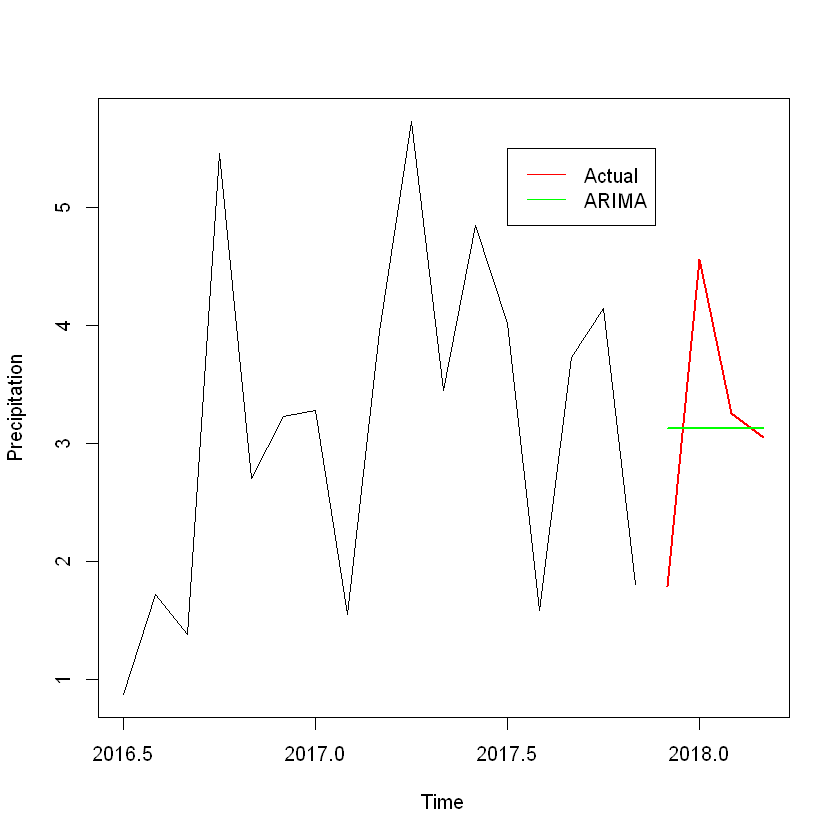

In [73]:
precip_predict = as.numeric(predict(arima(precip,order = c(0,1,1)),n.ahead = 4)$pred)
plot(time[(n-20):n], precip[(n-20):n], type="l",  xlab="Time", ylab="Precipitation") # contains training data
lines(time[(n-3):n],data_split$Precip[(n-3):n],col="red",lwd=2)
lines(time[(n-3):n],precip_predict,col="green",lwd=2)
legend(2017.5,5.5,legend=c("Actual","ARIMA"),col=c("red","green"),lty=1)

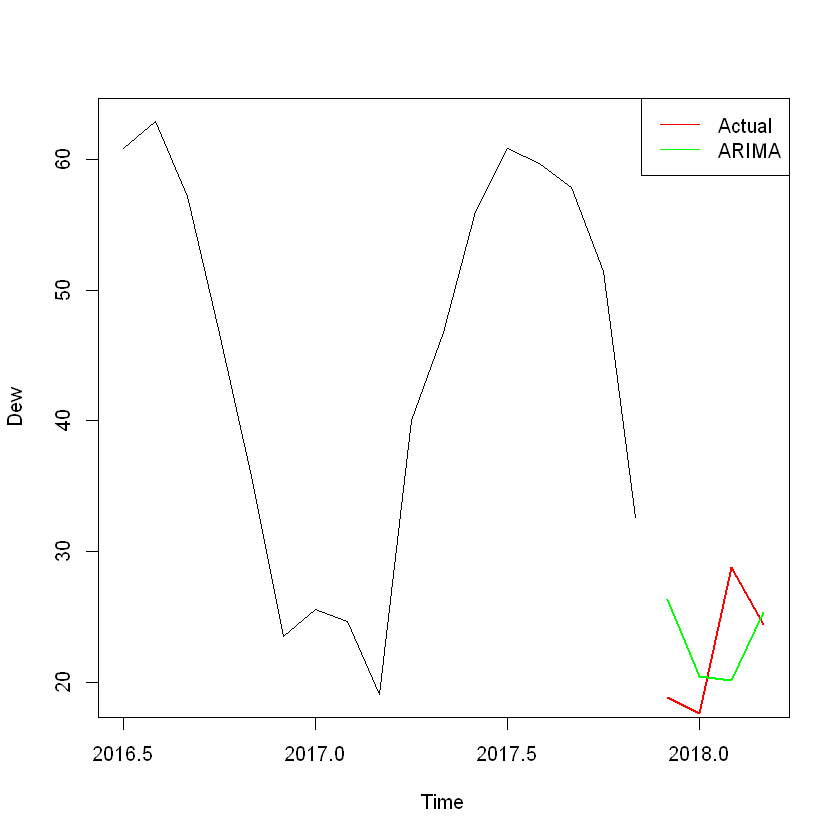

In [74]:
dew_predict = as.numeric(predict(arima(dew,order = c(2,1,3)),n.ahead = 4)$pred)
plot(time[(n-20):n], dew[(n-20):n], type="l",  xlab="Time", ylab="Dew") # contains training data
lines(time[(n-3):n],data_split$AverageDewPoint[(n-3):n],col="red",lwd=2)
lines(time[(n-3):n],dew_predict,col="green",lwd=2)
legend(x = "topright",legend=c("Actual","ARIMA"),col=c("red","green"),lty=1)

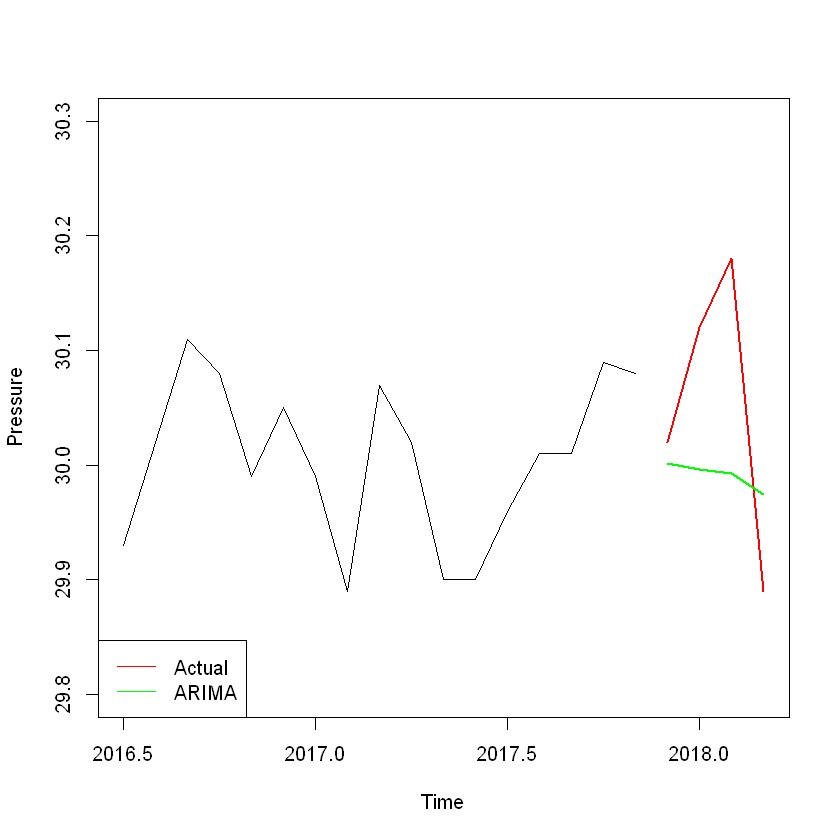

In [75]:
pressure_predict = as.numeric(predict(arima(pressure,order = c(5,1,3)),n.ahead = 4)$pred)
plot(time[(n-20):n], pressure[(n-20):n], type="l",  ylim = c(29.8,30.3),xlab="Time", ylab="Pressure") # contains training data
lines(time[(n-3):n],snow.test$AverageSeaLevelPressure,col="red",lwd=2)
lines(time[(n-3):n],pressure_predict,col="green",lwd=2)
legend(x = "bottomleft",legend=c("Actual","ARIMA"),col=c("red","green"),lty=1)

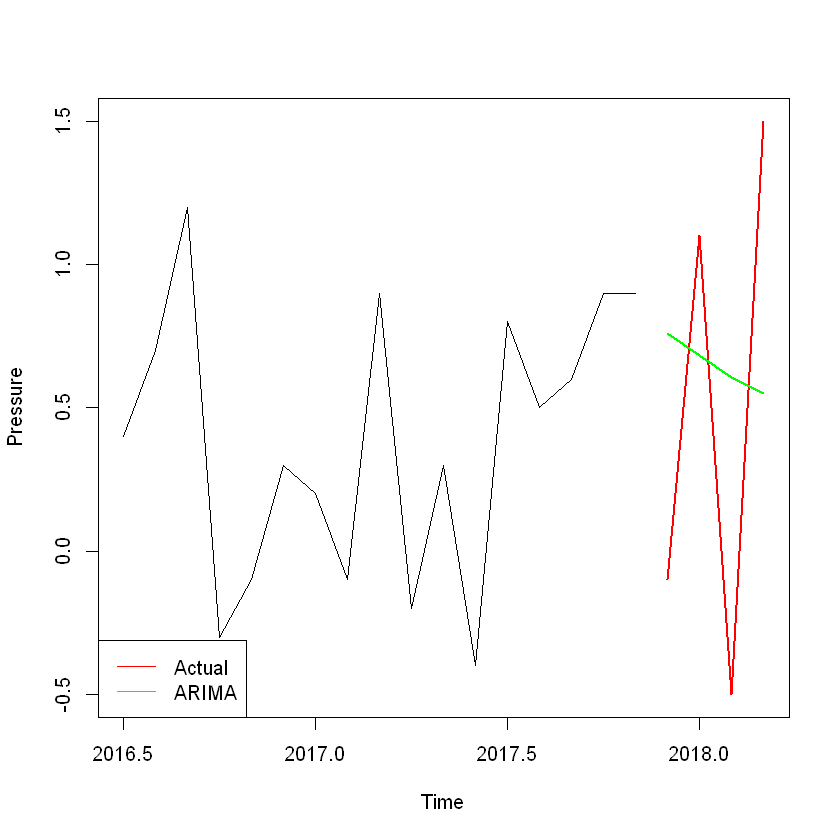

In [76]:
soi_predict = as.numeric(predict(arima(soi,order = c(2,1,1)),n.ahead = 4)$pred)
plot(time[(n-20):n], soi[(n-20):n], type="l",ylim = c(-0.5,1.5),xlab="Time", ylab="Pressure") # contains training data
lines(time[(n-3):n],snow.test$SOI,col="red",lwd=2)
lines(time[(n-3):n],soi_predict,col="green",lwd=2)
legend(x = "bottomleft",legend=c("Actual","ARIMA"),col=c("red","green"),lty=1)


_Question 3: Multivariate Analysis_

_Identify the best VAR model that fits the four time series simultaneously according to AIC (limit the maximum lag to 12).
Fit a VAR(2) model and check the model fitting using the multivariate ARCH test, the Jarque-Bera test and the Portmanteau test. 
State which assumptions are satisfied and which are violated.
Give the forecasts for the last four months of the data for the four time series using VAR(2) model._

Identify the best VAR model that fits the four time series simultaneously according to AIC (limit the maximum lag to 12). 

In [78]:
# select the best model using the VARselect functio
train_data_all = cbind(d_precip,d_dew,d_pressure,d_soi)
VARmodel = VARselect(train_data_all,lag.max = 12,type = "none")
AIC_order = VARmodel$selection[1]
print (AIC_order)
# The selected order is 11


AIC(n) 
    11 


The best order according to AIC criteria is 11

_Fit a VAR(2) model and check the model fitting using the multivariate ARCH test, the Jarque-Bera test and the Portmanteau test._

In [79]:
Var2_model = VAR(train_data_all,p = 2,type = "none")

In [85]:
#arch test  #test for nonconstant variance
arch.test(Var2_model)






	ARCH (multivariate)

data:  Residuals of VAR object Var2_model
Chi-squared = 508.2, df = 500, p-value = 0.3901

$arch.mul

	ARCH (multivariate)

data:  Residuals of VAR object Var2_model
Chi-squared = 508.2, df = 500, p-value = 0.3901



The ARCH test shows a p value of 0.3901, far greater than 0.05. Then we failed to reject the null hypothesis of constant variance (homoscedasticity), which is a good thing. 

In [84]:
#JB test   #test for normalit
normality.test(Var2_model)

$JB

	JB-Test (multivariate)

data:  Residuals of VAR object Var2_model
Chi-squared = 212.22, df = 8, p-value < 2.2e-16


$Skewness

	Skewness only (multivariate)

data:  Residuals of VAR object Var2_model
Chi-squared = 43.223, df = 4, p-value = 9.3e-09


$Kurtosis

	Kurtosis only (multivariate)

data:  Residuals of VAR object Var2_model
Chi-squared = 168.99, df = 4, p-value < 2.2e-16


$jb.mul
$jb.mul$JB

	JB-Test (multivariate)

data:  Residuals of VAR object Var2_model
Chi-squared = 212.22, df = 8, p-value < 2.2e-16


$jb.mul$Skewness

	Skewness only (multivariate)

data:  Residuals of VAR object Var2_model
Chi-squared = 43.223, df = 4, p-value = 9.3e-09


$jb.mul$Kurtosis

	Kurtosis only (multivariate)

data:  Residuals of VAR object Var2_model
Chi-squared = 168.99, df = 4, p-value < 2.2e-16




JB test shows a p value close to zero, whcih means that we reject the null hypothesis or normality. Thus the normality assumption of the model is violated. 

In [88]:
#Portmanteau test   #for uncorrelated residuals
serial_test = serial.test(Var2_model)
serial_test;
#plot(serial_test)


	Portmanteau Test (asymptotic)

data:  Residuals of VAR object Var2_model
Chi-squared = 377.5, df = 224, p-value = 6.057e-10

$serial

	Portmanteau Test (asymptotic)

data:  Residuals of VAR object Var2_model
Chi-squared = 377.5, df = 224, p-value = 6.057e-10



The portmanteau test shows a p value close to zero, which means that residuals of the model maybe correlated. 

_perform prediction of the four time series_

In [89]:
# perform prediction of the four time series
## Model Forecasting

Var2_predict=predict(Var2_model,n.ahead=4)
# this output contains fcst, lower, upper, and the range of confidence interval (on-side)
Var2_predict

$d_precip
            fcst     lower    upper       CI
[1,]  0.80128721 -3.726720 5.329294 4.528007
[2,] -0.05118938 -5.410091 5.307712 5.358902
[3,] -0.50915262 -5.919681 4.901375 5.410528
[4,]  0.17468473 -5.335077 5.684446 5.509761

$d_dew
           fcst     lower     upper       CI
[1,] -10.153977 -25.18162  4.873662 15.02764
[2,]  -6.297245 -23.31400 10.719511 17.01676
[3,]  -4.665423 -23.10350 13.772656 18.43808
[4,]  -2.653521 -21.45895 16.151909 18.80543

$d_pressure
             fcst      lower     upper        CI
[1,]  0.007612397 -0.1668601 0.1820849 0.1744725
[2,] -0.021106865 -0.2229451 0.1807313 0.2018382
[3,]  0.004464141 -0.2014128 0.2103410 0.2058769
[4,]  0.001460137 -0.2057901 0.2087104 0.2072503

$d_soi
            fcst     lower    upper       CI
[1,] -0.03712680 -1.443746 1.369492 1.406619
[2,]  0.09564155 -1.441534 1.632817 1.537175
[3,]  0.06841529 -1.474964 1.611795 1.543380
[4,] -0.02114205 -1.569014 1.526730 1.547872


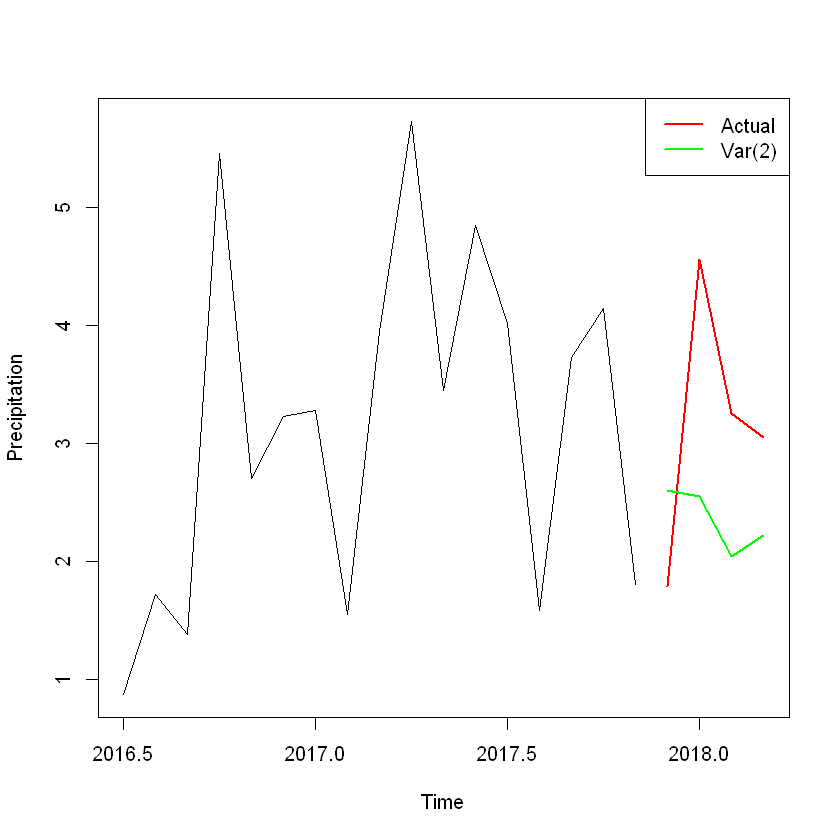

In [90]:
######### For Precip Data ########
Var2_precip_predict = ts(Var2_predict$fcst$d_precip[,1],frequency=12)  # The forecast value of precip
Var2_precip_lower = Var2_predict$fcst$d_precip[,2]
Var2_precip_upper = Var2_predict$fcst$d_precip[,3]

precip_train_predict= ts(c(d_precip,Var2_precip_predict),start=c(2008,2),frequency=12)  #combine the training data and the prediction into a single time series
precip_train_predict = diffinv(precip_train_predict,xi=precip[1])  #undifference the time series to obtain acutal data

par(mfrow=c(1,1))
plot(time[(n-20):n], precip[(n-20):n], type="l",xlab="Time", ylab="Precipitation") # contains training data
lines(time[(n-3):n],snow.test$Precip,col="red",lwd=2)  # actual data
lines(time[(n-3):n],precip_train_predict[(n-3):n],col="green",lwd=2)  # forcast data
legend(x = "topright",legend=c("Actual","Var(2)"),col=c("red","green"),lty=1,lwd=2) # Add Legend


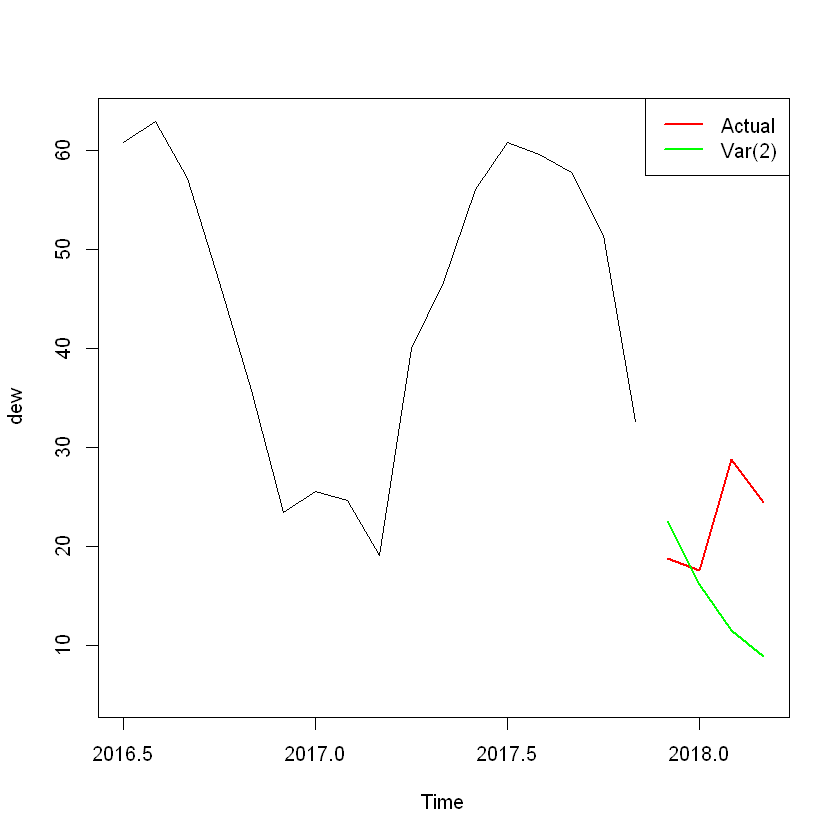

In [91]:
######### For Dew Point Data ########

Var2_dew_predict = ts(Var2_predict$fcst$d_dew[,1],frequency=12)  # The forecast value of dew
Var2_dew_lower = Var2_predict$fcst$d_dew[,2]
Var2_dew_upper = Var2_predict$fcst$d_dew[,3]

dew_train_predict= ts(c(d_dew,Var2_dew_predict),start=c(2008,2),frequency=12)  #combine the training data and the prediction into a single time series
dew_train_predict = diffinv(dew_train_predict,xi=dew[1])  #undifference the time series to obtain acutal data

par(mfrow=c(1,1))
plot(time[(n-20):n], dew[(n-20):n], type="l",xlab="Time", ylab="dew",ylim = c(5,63)) # contains training data
lines(time[(n-3):n],snow.test$AverageDewPoint,col="red",lwd=2)  # actual data
lines(time[(n-3):n],dew_train_predict[(n-3):n],col="green",lwd=2)  # forcast data
legend(x = "topright",legend=c("Actual","Var(2)"),col=c("red","green"),lty=1,lwd=2) # Add Legend

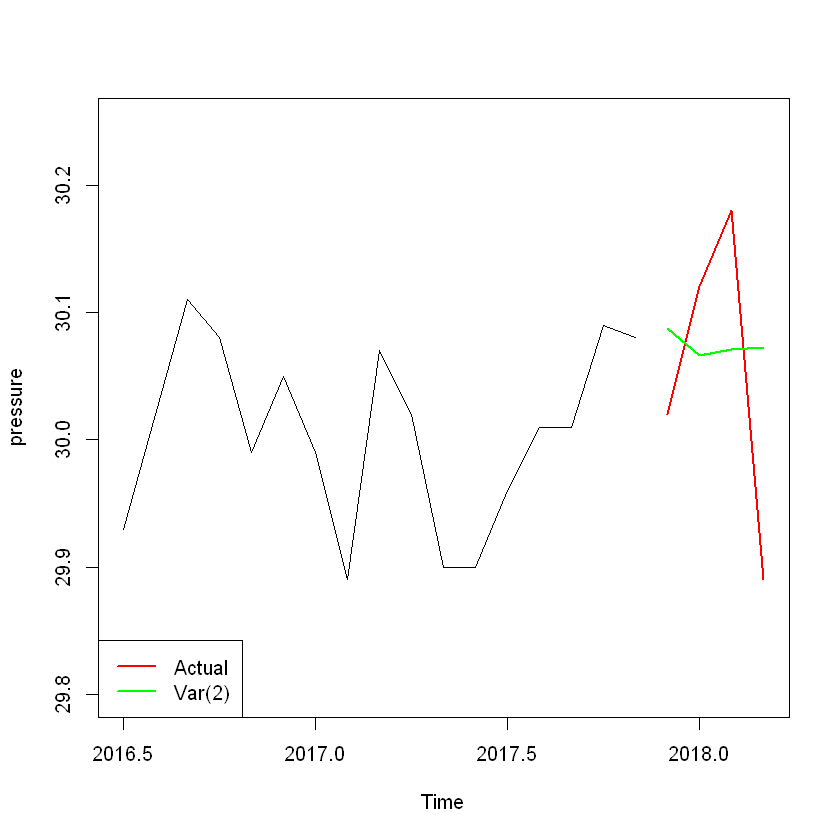

In [92]:
####### For Pressure Data ##########

Var2_pressure_predict = ts(Var2_predict$fcst$d_pressure[,1],frequency=12)  # The forecast value of pressure
Var2_pressure_lower = Var2_predict$fcst$d_pressure[,2]
Var2_pressure_upper = Var2_predict$fcst$d_pressure[,3]

pressure_train_predict= ts(c(d_pressure,Var2_pressure_predict),start=c(2008,2),frequency=12)  #combine the training data and the prediction into a single time series
pressure_train_predict = diffinv(pressure_train_predict,xi=pressure[1])  #undifference the time series to obtain acutal data

par(mfrow=c(1,1))
plot(time[(n-20):n], pressure[(n-20):n], type="l",xlab="Time", ylim = c(29.8,30.25),ylab="pressure") # contains training data
lines(time[(n-3):n],snow.test$AverageSeaLevelPressure,col="red",lwd=2)  # actual data
lines(time[(n-3):n],pressure_train_predict[(n-3):n],col="green",lwd=2)  # forcast data
legend(x = "bottomleft",legend=c("Actual","Var(2)"),col=c("red","green"),lty=1,lwd=2) # Add Legend


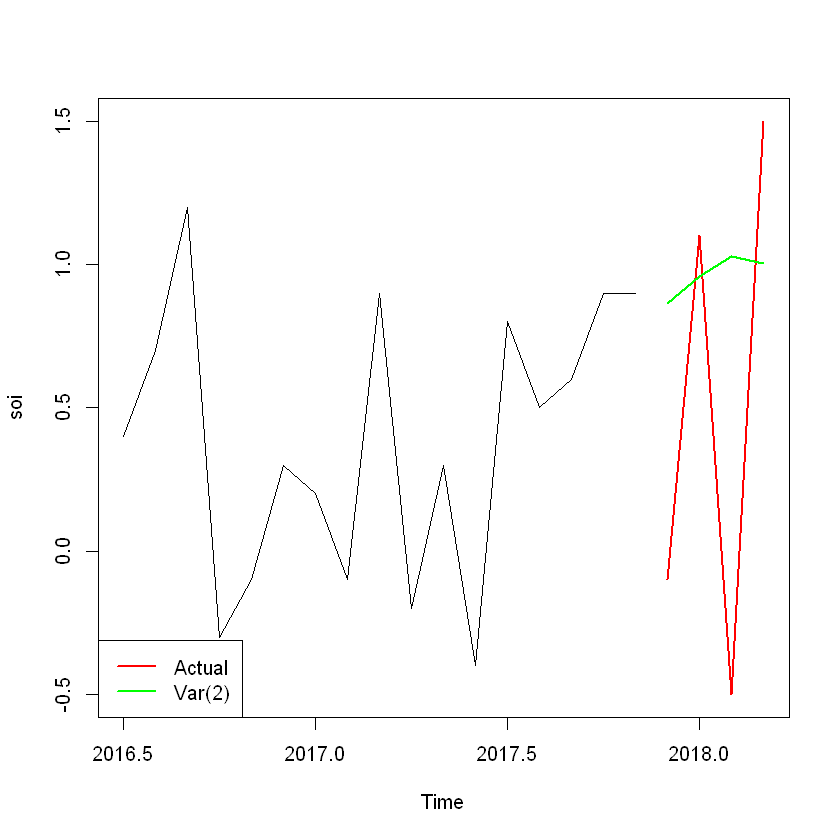

In [93]:
####### For SOI Data ##########

Var2_soi_predict = ts(Var2_predict$fcst$d_soi[,1],frequency=12)  # The forecast value of soi
Var2_soi_lower = Var2_predict$fcst$d_soi[,2]
Var2_soi_upper = Var2_predict$fcst$d_soi[,3]

soi_train_predict= ts(c(d_soi,Var2_soi_predict),start=c(2008,2),frequency=12)  #combine the training data and the prediction into a single time series
soi_train_predict = diffinv(soi_train_predict,xi=soi[1])  #undifference the time series to obtain acutal data

par(mfrow=c(1,1))
plot(time[(n-20):n], soi[(n-20):n], type="l",xlab="Time",ylim = c(-0.5,1.5), ylab="soi") # contains training data
lines(time[(n-3):n],snow.test$SOI,col="red",lwd=2)  # actual data
lines(time[(n-3):n],soi_train_predict[(n-3):n],col="green",lwd=2)  # forcast data
legend(x = "bottomleft",legend=c("Actual","Var(2)"),col=c("red","green"),lty=1,lwd=2) # Add Legend


_Question 4: Predictions_

_Using mean absolute prediction error and mean square prediction error, compare the predictions for the 
four time series derived from the univariate analysis and multivariate analysis._

Define a helper function to calculate teh precision measure

In [100]:
cal_accuracy = function(predicted,actual,printing = T,var_name = ""){
  ### Mean Squared Prediction Error (MSPE)
  MSPE = mean((predicted-actual)^2)
  ### Mean Absolute Prediction Error (MAE)
  #MAE = mean(abs(predicted-actual))
  ### Mean Absolute Percentage Error (MAPE)
  MAPE = mean(abs(predicted-actual)/actual)
  ### Precision Measure (PM)
  #PM = sum((predicted-actual)^2)/sum((actual-mean(actual))^2)
  
  if (printing == T) {
    cat("For the time series",var_name, ": \n")
    cat ("The MSPE is", MSPE,"\n")
    #cat ("The MAE is", MAE,"\n")
    cat ("The MAPE is", MAPE,"\n")
    #cat ("The PM is", PM,"\n")
    cat("\n")
  }
  
  result = list()
  result$MSPE = MSPE
  #result$MAE = MAE
  result$MAPE = MAPE
  #result$PM = PM
  
  return (result)
}

for univariate analysis

In [101]:
print ("Accuarcy Measure for Univariate analysis")
uni_precip_accuracy = cal_accuracy(predicted = precip_predict,actual = snow.test$Precip,var_name = "Precipitation")
uni_dew_accuracy = cal_accuracy(predicted = dew_predict,actual = snow.test$AverageDewPoint,var_name = "Dew")
uni_pressure_accuracy = cal_accuracy(predicted = pressure_predict,actual = snow.test$AverageSeaLevelPressure,var_name = "Pressure")
uni_soi_accuracy = cal_accuracy(predicted = soi_predict,actual = snow.test$SOI,var_name = "SOI")

[1] "Accuarcy Measure for Univariate analysis"
For the time series Precipitation : 
The MSPE is 0.9654081 
The MAPE is 0.2812253 

For the time series Dew : 
The MSPE is 35.36925 
The MAPE is 0.2256615 

For the time series Pressure : 
The MSPE is 0.01443044 
The MAPE is 0.003435045 

For the time series SOI : 
The MSPE is 0.7606514 
The MAPE is -2.447221 



For multivariate analysis

In [99]:
print ("Accuarcy Measure for Multivariate analysis")
mul_precip_accuracy = cal_accuracy(predicted = as.numeric(precip_train_predict[(n-3):n]),actual = snow.test$Precip,var_name = "Precipitation")
mul_dew_accuracy = cal_accuracy(predicted = as.numeric(dew_train_predict[(n-3):n]),actual = snow.test$AverageDewPoint,var_name = "Dew")
mul_pressure_accuracy = cal_accuracy(predicted = as.numeric(pressure_train_predict[(n-3):n]),actual = snow.test$AverageSeaLevelPressure,var_name = "Pressure")
mul_soi_accuracy = cal_accuracy(predicted = as.numeric(soi_train_predict[(n-3):n]),actual = snow.test$SOI,var_name = "SOI")

[1] "Accuarcy Measure for Multivariate analysis"
For the time series Precipitation : 
The MSPE is 1.71397 
The MAPE is 0.3848955 

For the time series Dew : 
The MSPE is 138.9233 
The MAPE is 0.3779339 

For the time series Pressure : 
The MSPE is 0.01315034 
The MAPE is 0.003436083 

For the time series SOI : 
The MSPE is 0.8807259 
The MAPE is -3.056124 



For Precipitation, Dew Point, and SOI, the univaraite analysis is better than Multivariate analysis because both MAPE and MSPE are lower for the univariate analysis. 

For the Pressure, the two models outputs about the same accuracy measures